**Brief description**
---------------------

The Dataset is an anonymized sample of over 3,000,000 grocery orders from more than 200,000 Instacart users. 
The goal of a competition is to predict which previously purchased products will be in a user’s next order.
In this kernel, we will try to explore the data. Try to understand relationship between various features of the data before we move on to prediction model.

Loading Modules:
----------------

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

Loading Datsets:
----------------

In [17]:
aisles = pd.read_csv('../input/aisles.csv', engine='c')
departments = pd.read_csv('../input/departments.csv', engine='c')
products = pd.read_csv('../input/products.csv', engine='c')
#Making one dataframe for commodities
df_com = pd.merge(left=pd.merge(left=products, right=aisles, how='left'), right=departments, how='left')

df_train = pd.read_csv('../input/order_products__train.csv', engine='c')
df_prior = pd.read_csv('../input/order_products__prior.csv', engine='c')
orders = pd.read_csv('../input/orders.csv', engine='c')

In [18]:
del aisles
df_com.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Consolidating Train Data with Orders and Commodity DataFrame
------------------------------------------------------------

In [19]:
df_train = pd.merge(left = (pd.merge(left = df_train, right = orders, how = 'left', on = 'order_id')), right = df_com[['product_id', 'aisle_id', 'department_id']], how = 'left', on = 'product_id')
del orders
df_train['reordered'] = df_train.add_to_cart_order*df_train.reordered
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,120,16
1,1,11109,2,2,112108,train,4,4,10,9.0,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,83,4
4,1,43633,5,5,112108,train,4,4,10,9.0,95,15


How are various Aisles distributed amongst various Departments?
---------------------------------------------------------------

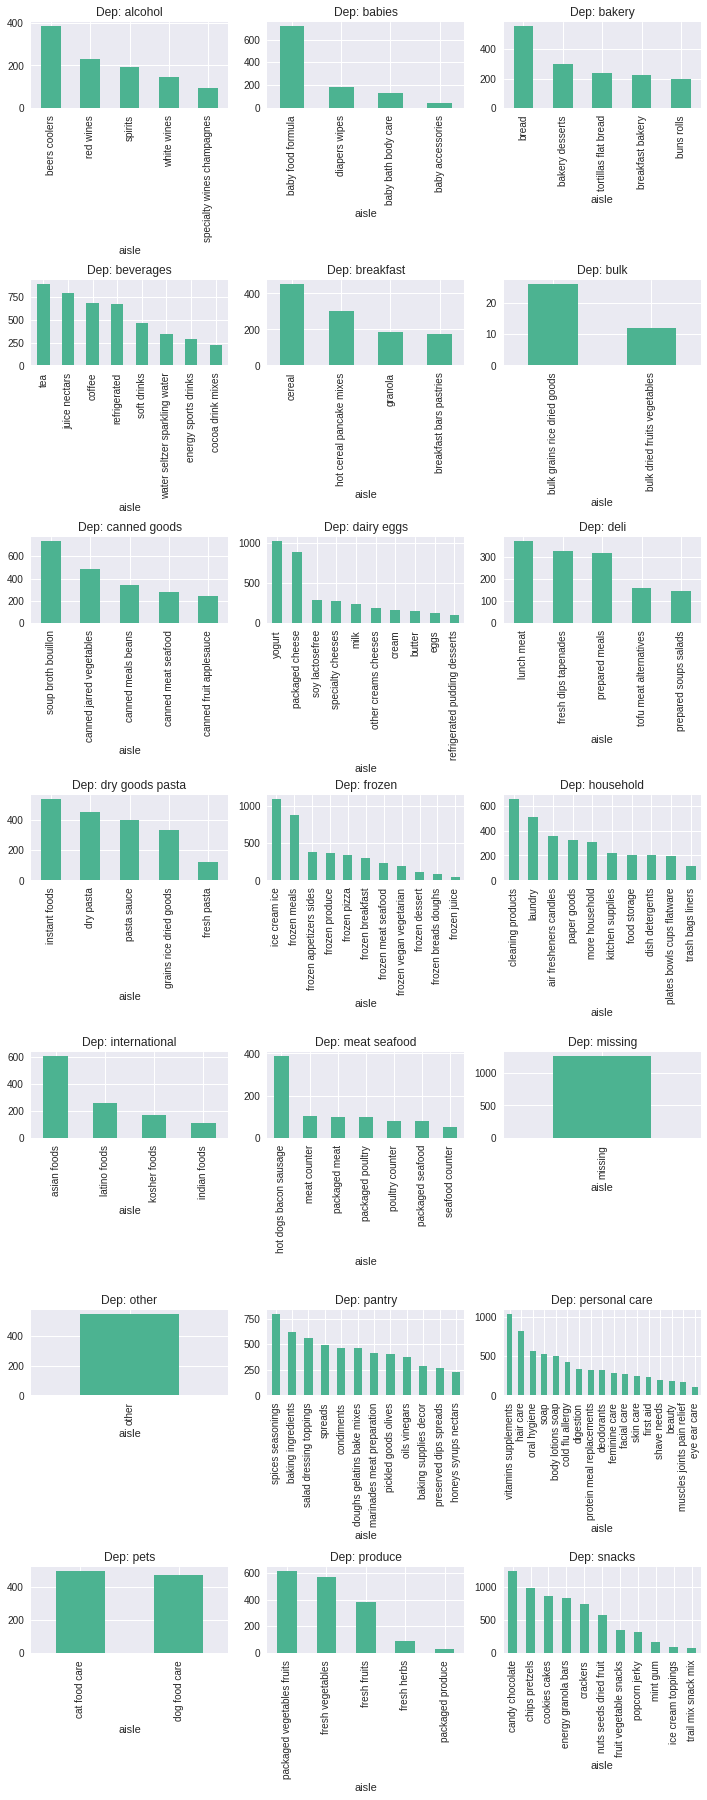

In [6]:
f, axarr = plt.subplots(7, 3, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//3, i%3].set_title('Dep: {}'.format(e))
    df_com[df_com.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', color="#4CB391", ax=axarr[i//3, i%3])
f.subplots_adjust(hspace=2)

Relationship between Products[Top-50] Ordering and Re-ordering:
----------------------------------------

In [7]:
aggregations = {'add_to_cart_order':'sum', 'reordered':'sum'}
prod_reorder = df_train.groupby('product_id').agg(aggregations)
prod_reorder = prod_reorder.sort_values('add_to_cart_order', ascending=False)[:50]

prod_user = df_train.groupby('user_id').agg(aggregations)
prod_user = prod_user.sort_values('add_to_cart_order', ascending=False)[:50]

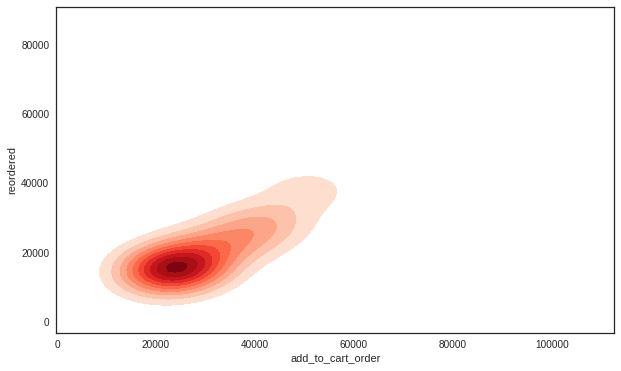

In [8]:
sns.set(style="white")

# Set up the figure
f, ax = plt.subplots(figsize=(10, 6))

# Draw the two density plots
ax = sns.kdeplot(prod_reorder.add_to_cart_order, prod_reorder.reordered,
                 cmap="Reds", shade=True, shade_lowest=False)

Relationship between Users[Top-50] Ordering and Re-ordering:
----------------------------------------

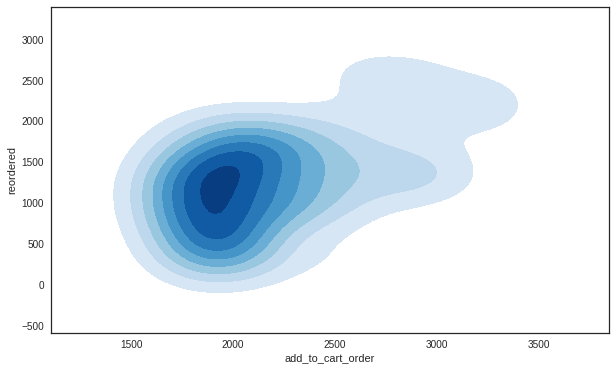

In [9]:
sns.set(style="white")

# Set up the figure
f, ax = plt.subplots(figsize=(10, 6))

# Draw the two density plots
ax = sns.kdeplot(prod_user.add_to_cart_order, prod_user.reordered,
                 cmap="Blues", shade=True, shade_lowest=False)

Relationship between re-ordering and days_since_prior_order:
------------------------------------------------------------

*Due to so many data points, we are taking top 8000 points to understand the distribution.*

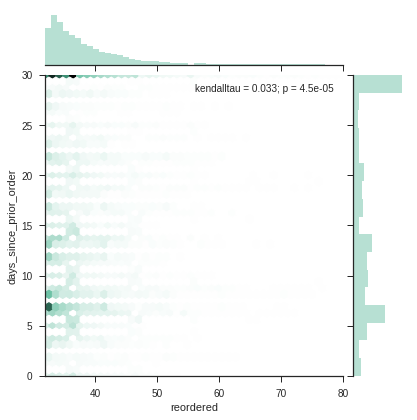

In [23]:
from scipy.stats import kendalltau

df_train1 = df_train.sort_values('reordered', ascending=False)[:8000]

sns.set(style="ticks")

x = df_train1.reordered
y = df_train1.days_since_prior_order

sns.jointplot(x, y, kind="hex", stat_func=kendalltau, color="#4CB391")

Takeaways:
----------

 - Various aisles show Chi Square distribution when studied department-wise
 - Most of the re-ordered products are fixed with few outliers and little variance in re-ordering
 - KDE plot of user-wise[Top-50] re-ordering shows that the plot is less flat (as compared to product-wise chart). Chart shows high variance, which indicates that there is a scope of user retention and acquisition and hence requirement of machine learning classifier to understand user behavior.
 - Again, re-ordering has chi squared distribution.
 - Most of the re-ordering is done on weekly, bi-weekly and monthly basis

 